**Step 1: Set Up Kafka for Streaming Stock Data**

### **Installing confluent-kafka**

In [0]:
!pip install confluent-kafka


In [0]:
%pip install --upgrade pip


Python interpreter will be restarted.
Python interpreter will be restarted.


**1. Importing Necessary Libraries and Setting Configuration**

In [0]:
import json
import time
from datetime import datetime, timedelta
import random
from confluent_kafka import Producer

# Kafka configuration
conf = {
    'bootstrap.servers': 'pkc-619z3.us-east1.gcp.confluent.cloud:9092',  
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': 'O3LJJAT5NL2RRB6G',  
    'sasl.password': 'wTc8QOLiu7ZU5PEXIUNB2BlHp23S5LLEJnOBbK4TeRWGjYVsDFHeN9RPYD8WN/Oo', 
}


**2. Kafka Producer Setup:**

In [0]:

# Initialize Kafka Producer
producer = Producer(conf)

# Kafka topic
topic = 'stock'  # The topic name

**Set Up PySpark Streaming in Databricks**

**1. Import necessary libraries**

In [0]:

%python
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import col, window, avg
from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType



**2. Configure Spark Session for Kafka:**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, avg, max, min

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Real-Time Stock Price Analysis") \
    .getOrCreate()






**Step 3: Define Schema for Stock Price Data**

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType, IntegerType

# Define schema with ticker, price, timestamp, and volume
schema = StructType([
    StructField("ticker", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("volume", IntegerType(), True) 
])



**Step 4: Read Data from Kafka**

In [0]:
kafka_stream_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "pkc-619z3.us-east1.gcp.confluent.cloud:9092") \
    .option("subscribe", "stock") \
    .load()


In [0]:
stock_df = kafka_stream_df \
    .selectExpr("CAST(value AS STRING)") \
    .select("value") \
    .selectExpr("json_tuple(value, 'ticker', 'price', 'timestamp') as (ticker, price, timestamp)") \
    .withColumn("timestamp", col("timestamp").cast(TimestampType())) \
    .withColumn("price", col("price").cast(FloatType()))


In [0]:
stock_stream = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "pkc-619z3.us-east1.gcp.confluent.cloud:9092") \
    .option("subscribe", "stock") \
    .option("startingOffsets", "earliest") \
    .load()

# Deserialize Kafka value and parse JSON
from pyspark.sql.functions import from_json, col

parsed_stream = stock_stream.select(
    from_json(col("value").cast("string"), schema).alias("data")
).select("data.*")


In [0]:
# Get the status of the running streaming query
query = parsed_stream.writeStream \
                     .format("delta") \
                     .outputMode("append") \
                     .option("checkpointLocation", "/mnt/checkpoints/stock_value") \
                     .start("/mnt/checkpoints/stock_value")

# Monitor the stream query status (real-time data)
query.status 


In [0]:
# Monitor the streaming query status
import time

while query.isActive:
    print(query.status)  # Print the status of the query
    time.sleep(5)  # Wait for 5 seconds before checking again

# Stop the query (optional, if you want to stop manually)
query.stop()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2239590077227200>:4
      1 # Monitor the streaming query status
      2 import time
----> 4 while query.isActive:
      5     print(query.status)  # Print the status of the query
      6     time.sleep(5)  # Wait for 5 seconds before checking again

NameError: name 'query' is not defined

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Define the WindowSpec
window_spec = Window.partitionBy().orderBy(F.col("timestamp")).rowsBetween(-10, 0)

# Calculate the moving average
processed_stream = parsed_stream.withColumn(
    "moving_avg",
    F.avg("price").over(window_spec)
)



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, FloatType, TimestampType, IntegerType

# Initialize Spark session
spark = SparkSession.builder.appName("StockPriceProcessing").getOrCreate()

# Sample schema definition 
schema = StructType([
    StructField("ticker", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("volume", IntegerType(), True)
])

# Example DataFrame loading (replace with your actual data source)


# Define the WindowSpec for moving average calculation (with no partitioning)
window_spec = Window.orderBy(F.col("timestamp"))

# Calculate the moving average of 'price'
processed_stream = parsed_stream.withColumn(
    "moving_avg",
    F.avg("price").over(window_spec)
)

# Print the schema to ensure the columns are correct
processed_stream.printSchema()


root
 |-- ticker: string (nullable = true)
 |-- price: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- volume: integer (nullable = true)
 |-- moving_avg: double (nullable = true)



In [0]:
parsed_stream.printSchema()

root
 |-- ticker: string (nullable = true)
 |-- price: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- volume: integer (nullable = true)



**Step 6: Data Processing and Analysis in Real Time**

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session (if not already initialized)
spark = SparkSession.builder.appName("DeltaTableRead").getOrCreate()

# Path to the Delta table
delta_table_path = "/mnt/delta/stock_value/"

# Read the Delta table
df = spark.read.format("delta").load(delta_table_path)

# Display the contents of the Delta table
df.show()

+------+------+-------------------+
|ticker| price|          timestamp|
+------+------+-------------------+
|  MSFT|491.57|2024-12-10 03:34:10|
|  AAPL|336.44|2024-12-10 11:39:47|
|  MSFT| 353.1|2024-12-09 19:08:30|
|  AAPL|344.76|2024-12-10 11:30:21|
|  AAPL|110.14|2024-12-10 03:43:46|
|  AAPL|115.66|2024-12-09 23:29:23|
|  AAPL|448.05|2024-12-10 06:07:28|
|  MSFT|241.56|2024-12-10 03:42:26|
|  MSFT|362.79|2024-12-09 21:20:56|
|  AAPL|370.28|2024-12-10 06:01:27|
|  AAPL|192.62|2024-12-09 23:11:52|
|  AAPL|392.34|2024-12-10 06:05:33|
|  AAPL|481.58|2024-12-10 11:52:48|
|  AAPL|313.23|2024-12-10 03:55:52|
|  MSFT|189.91|2024-12-09 19:08:35|
|  MSFT|381.72|2024-12-09 23:29:03|
|  AAPL|151.62|2024-12-10 05:49:37|
|  MSFT|488.23|2024-12-09 21:49:17|
|  MSFT|329.88|2024-12-09 23:16:22|
|  MSFT|257.62|2024-12-09 21:59:52|
+------+------+-------------------+
only showing top 20 rows



In [0]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import col, avg, sum, max, to_date

# Define the schema for the daily summary table
daily_summary_schema = StructType([
    StructField("date", StringType(), True),
    StructField("ticker", StringType(), True),
    StructField("avg_price", DoubleType(), True),
    StructField("max_price", DoubleType(), True),
    StructField("total_volume", DoubleType(), True),
    StructField("total_price", DoubleType(), True)
])

# Read stock price data from the Delta table
df = spark.read.format("delta").load("/mnt/delta/stock_value")

# Convert timestamps to date (will aggregate by date)
df = df.withColumn("date", to_date(col("timestamp")))

# Group by date and symbol to calculate daily summary statistics
daily_summary = df.groupBy("date", "ticker") \
    .agg(
        avg("price").alias("avg_price"),
        max("price").alias("max_price"),

        sum("price").alias("total_price")  # Assuming you want sum as total value; replace if needed
    )

# Write daily summary to a Delta table (append mode)
daily_summary.write.format("delta").mode("append").save("/mnt/delta/daily_summary")



Creating the tigger if price changes

In [0]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

# Calculate price change percentage
window_spec = Window.partitionBy("ticker").orderBy("timestamp")
price_change = parsed_stream.withColumn(
    "prev_price", lag("price").over(window_spec)
).withColumn(
    "price_change_percent",
    (col("price") - col("prev_price")) / col("prev_price") * 100
)

# Filter significant price changes
alerts = price_change.filter((col("price_change_percent") > 5) | (col("price_change_percent") < -5))

**Step6 : Streaming Data Sink and Visualization**

In [0]:
!pip install matplotlib seaborn


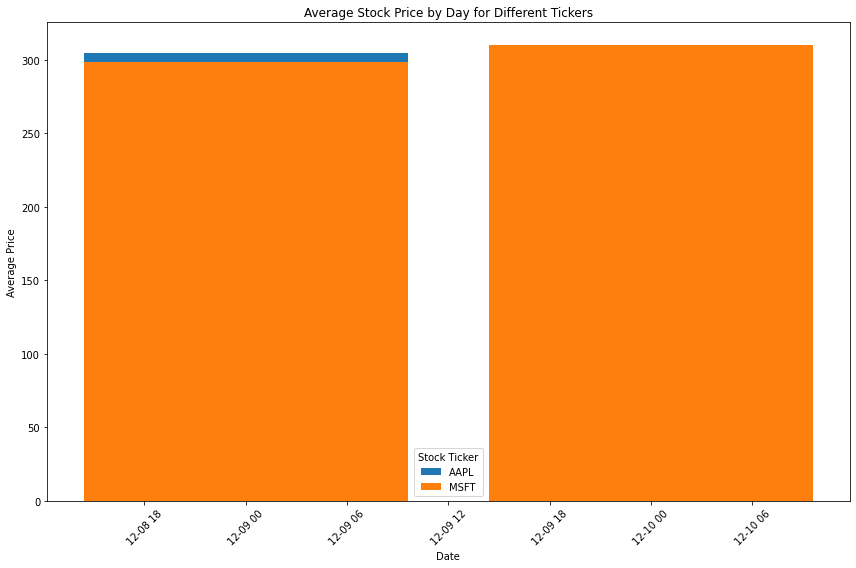

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame if needed
pandas_df = df.toPandas()

# Ensure 'timestamp' is in datetime format
pandas_df['timestamp'] = pd.to_datetime(pandas_df['timestamp'])

# Extract date from the timestamp
pandas_df['date'] = pandas_df['timestamp'].dt.date  # Extract date

# Calculate the average price by date and ticker
avg_price_by_day_ticker = pandas_df.groupby(['date', 'ticker'])['price'].mean().reset_index()

# Create a bar chart for each ticker
tickers = avg_price_by_day_ticker['ticker'].unique()

plt.figure(figsize=(12, 8))

# Plot bars for each ticker
for ticker in tickers:
    ticker_data = avg_price_by_day_ticker[avg_price_by_day_ticker['ticker'] == ticker]
    plt.bar(ticker_data['date'], ticker_data['price'], label=ticker)

plt.title('Average Stock Price by Day for Different Tickers')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.legend(title='Stock Ticker')
plt.tight_layout()

# Show the bar chart
plt.show()


In [0]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("DeltaTableRead").getOrCreate()

# Path to the Delta table
delta_table_path = "/mnt/delta/stock_value/"

# Read the Delta table
df = spark.read.format("delta").load(delta_table_path)

# Convert to Pandas DataFrame for easier plotting
pandas_df = df.toPandas()

# Check the first few rows of the dataframe
print(pandas_df.head())

#



  ticker       price           timestamp
0   MSFT  153.729996 2024-12-09 22:08:57
1   AAPL  210.369995 2024-12-09 22:04:52
2   AAPL  438.109985 2024-12-09 23:39:59
3   AAPL  405.399994 2024-12-10 11:59:23
4   AAPL  330.880005 2024-12-09 23:34:28


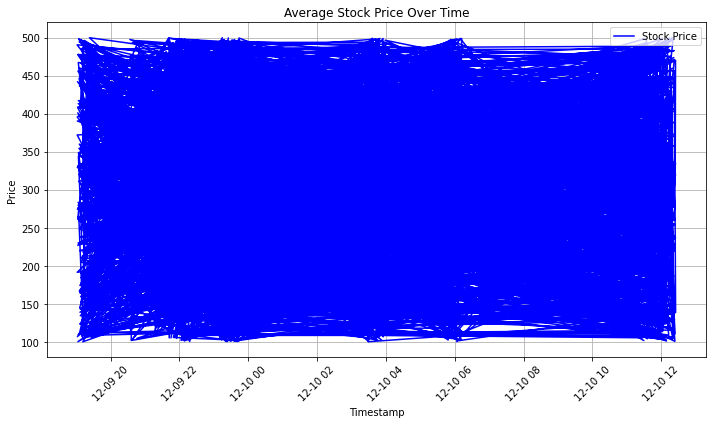

In [0]:
# 1. Average Price over time (Line chart)
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['timestamp'], pandas_df['price'], label='Stock Price', color='blue')
plt.title('Average Stock Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot for Average Price
plt.show()

In [0]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("DeltaTableRead").getOrCreate()

# Path to the Delta table
delta_table_path = "/mnt/delta/stock_value/"

# Read the Delta table
df = spark.read.format("delta").load(delta_table_path)

# Convert to Pandas DataFrame for easier handling
pandas_df = df.toPandas()

# Ensure 'timestamp' is in datetime format and 'price' is numeric
pandas_df['timestamp'] = pd.to_datetime(pandas_df['timestamp'], errors='coerce')  # Convert to datetime
pandas_df['price'] = pd.to_numeric(pandas_df['price'], errors='coerce')  # Convert price to numeric

# Get today's date
today_date = pd.to_datetime('today').normalize()

# Filter the data for today's date
today_data = pandas_df[pandas_df['timestamp'].dt.date == today_date.date()]

# Calculate Min, Max, and Median for today
min_price = today_data['price'].min()
max_price = today_data['price'].max()
median_price = today_data['price'].median()

# Print the results
print(f"Min Price for Today ({today_date.date()}): {min_price}")
print(f"Max Price for Today ({today_date.date()}): {max_price}")
print(f"Median Price for Today ({today_date.date()}): {median_price}")


Min Price for Today (2024-12-10): 100.06999969482422
Max Price for Today (2024-12-10): 499.9599914550781
Median Price for Today (2024-12-10): 299.8999938964844


**Step 7: Batch Processing for Daily Summary**

In [0]:
# Define the schema for the daily summary table
daily_summary_schema = StructType([
    StructField("date", StringType(), True),
    StructField("ticker", StringType(), True),
    StructField("avg_price", DoubleType(), True),
    StructField("max_price", DoubleType(), True),
    StructField("total_volume", DoubleType(), True),
    StructField("total_price", DoubleType(), True)
])

# Read stock price data from the Delta table
df = spark.read.format("delta").load("/mnt/delta/stock_value")

# Convert timestamps to date (will aggregate by date)
df = df.withColumn("date", to_date(col("timestamp")))

# Group by date and symbol to calculate daily summary statistics
daily_summary = df.groupBy("date", "ticker") \
    .agg(
        avg("price").alias("avg_price"),
        max("price").alias("max_price"),

        sum("price").alias("total_price")  # Assuming you want sum as total value; replace if needed
    )

# Write daily summary to a Delta table (append mode)
daily_summary.write.format("delta").mode("append").save("/mnt/delta/daily_summary")

In [0]:
# Convert the PySpark DataFrame to Pandas DataFrame
daily_summary_pandas = daily_summary.toPandas()